In [1]:
# notebooks/model_random_forest.ipynb

# Section 1: Import Libraries and Helpers
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the project root to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from helpers.visualization_helpers import plot_confusion_matrix, display_classification_report

In [2]:
# Section 2: Load Preprocessed Data

X_train = joblib.load('../outputs/models/X_train_balanced.joblib')
y_train = joblib.load('../outputs/models/y_train_balanced.joblib')
X_test = joblib.load('../outputs/models/X_test_tfidf.joblib')
y_test = joblib.load('../outputs/models/y_test.joblib')

print("Preprocessed data loaded successfully.")

# Section 3: Model Training

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=21)

# Train the model
rf_clf.fit(X_train, y_train)
print("\nRandom Forest Classifier trained successfully.")


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/models/X_train_balanced.joblib'

Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.68      0.63       284
           2       0.30      0.18      0.23       359
           3       0.32      0.16      0.21       437
           4       0.46      0.39      0.42      1208
           5       0.61      0.78      0.69      1811

    accuracy                           0.54      4099
   macro avg       0.45      0.44      0.43      4099
weighted avg       0.51      0.54      0.51      4099

Figure saved to ../outputs/figures/random_forest_confusion_matrix.png


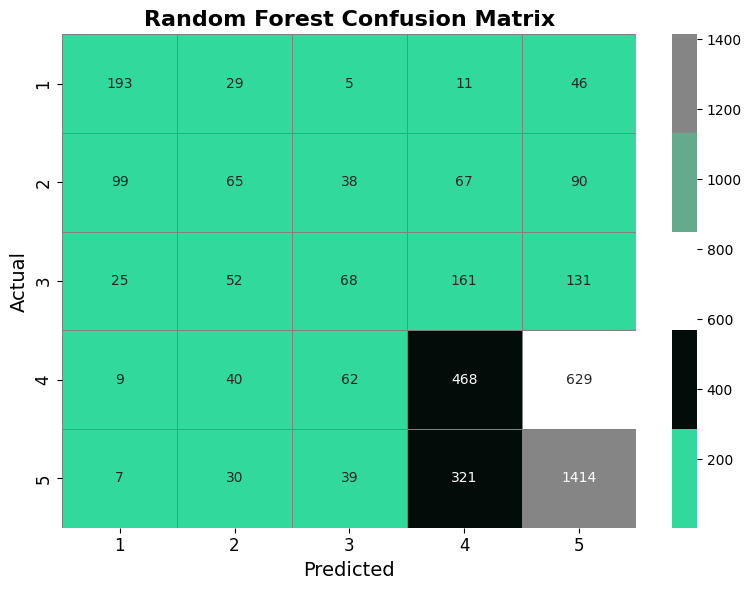


Random Forest Classifier model saved successfully.


In [ ]:

# Section 4: Model Evaluation

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Display Classification Report
display_classification_report(y_test, y_pred)

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred, 
                             classes=[1, 2, 3, 4, 5], 
                             title="Random Forest Confusion Matrix", 
                             save_path='../outputs/figures/random_forest_confusion_matrix.png')

# Section 5: Save the Trained Model

joblib.dump(rf_clf, '../outputs/models/random_forest_model.joblib')
print("\nRandom Forest Classifier model saved successfully.")


In [3]:
import joblib

# Load balanced datasets for TFIDF
X_train_tfidf = joblib.load('../outputs/models/X_train_tfidf_balanced.joblib')
y_train_tfidf = joblib.load('../outputs/models/y_train_tfidf_balanced.joblib')

# Load balanced datasets for BOW
X_train_bow = joblib.load('../outputs/models/X_train_bow_balanced.joblib')
y_train_bow = joblib.load('../outputs/models/y_train_bow_balanced.joblib')

# Load balanced datasets for spaCy
X_train_spacy = joblib.load('../outputs/models/X_train_spacy_balanced.joblib')
y_train_spacy = joblib.load('../outputs/models/y_train_spacy_balanced.joblib')


from sklearn.ensemble import RandomForestClassifier

# Random Forest with TFIDF
rf_tfidf = RandomForestClassifier(random_state=21)
rf_tfidf.fit(X_train_tfidf, y_train_tfidf)
joblib.dump(rf_tfidf, '../outputs/models/Random_Forest_TFIDF.joblib')

# Random Forest with BOW
rf_bow = RandomForestClassifier(random_state=21)
rf_bow.fit(X_train_bow, y_train_bow)
joblib.dump(rf_bow, '../outputs/models/Random_Forest_BOW.joblib')

# Random Forest with spaCy
rf_spacy = RandomForestClassifier(random_state=21)
rf_spacy.fit(X_train_spacy, y_train_spacy)
joblib.dump(rf_spacy, '../outputs/models/Random_Forest_SPACY.joblib')

['../outputs/models/Random_Forest_SPACY.joblib']